# Imports

In [1]:
import os.path
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns
import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Feb 25 2025 15:16:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Parameters

In [2]:
tau_syn = 0.32582722403722841
neuron_params = {
    "E_L": 0.0,
    "C_m": 250.0,
    "tau_m": 10.0,
    "t_ref": 0.5,
    "V_th": 20.0,
    "V_reset": 0.0,
    "tau_syn_ex": tau_syn,
    "tau_syn_in": tau_syn,
    "tau_minus": 30.0,
    "V_m": 5.7
}

stdp_params = {
    "alpha": 0.0513,
    "mu": 0.4,
    "tau_plus": 15.0,
    "weight": 45.
}

NE = 9000
eta = 4.92

single_column_in = 3.348

# Simulation

In [7]:
def run(T, axonal_delay, dendritic_delay, enable_stdp, use_ax_delay):
    if enable_stdp:
        stdp_params['lambda'] = 1.
    else:
        stdp_params['lambda'] = 0.

    nest.ResetKernel()
    nest.local_num_threads = 8
    nest.resolution = 0.1
    nest.rng_seed = 42
    nest.set_verbosity("M_ERROR")

    E_ext = nest.Create("poisson_generator", 1, {"rate": eta * 1000.0})
    E_pg = nest.Create("poisson_generator", 1, params={"rate": 10.0})
    I_pg = nest.Create("poisson_generator", 1, params={"rate": 10.0 * NE / 5})
    E_neurons = nest.Create("parrot_neuron", NE)
    I_neurons = nest.Create("parrot_neuron", 1)
    post_neuron = nest.Create("iaf_psc_alpha", 1, params=neuron_params)
    sr = nest.Create("spike_recorder")

    syn_params_copy = stdp_params.copy()
    if use_ax_delay:
        syn_params_copy["dendritic_delay"] = dendritic_delay
        syn_params_copy["axonal_delay"] = axonal_delay
        syn_model = "stdp_pl_synapse_hom_ax_delay"
    else:
        syn_params_copy["delay"] = dendritic_delay + axonal_delay
        syn_model = "stdp_pl_synapse_hom"

    nest.SetDefaults(syn_model, syn_params_copy)

    nest.Connect(E_pg, E_neurons)
    nest.Connect(I_pg, I_neurons)
    nest.Connect(E_neurons, post_neuron, syn_spec={"synapse_model": syn_model})
    nest.Connect(I_neurons, post_neuron, syn_spec={"weight": 45. * -5})
    nest.Connect(E_ext, post_neuron, syn_spec={"weight": 45.})
    nest.Connect(post_neuron, sr)

    nest.Simulate(T)

    return sr, post_neuron


def set_font_sizes(small=8, medium=10, large=12, family='Arial'):
    # plt.rc('text', usetex=True)
    plt.rc('font', size=small)  # controls default text sizes
    plt.rc('axes', titlesize=small)  # fontsize of the axes title
    plt.rc('axes', labelsize=medium)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=small)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=small)  # fontsize of the tick labels
    plt.rc('legend', fontsize=small)  # legend fontsize
    plt.rc('figure', titlesize=large)  # fontsize of the figure title
    plt.rc('font', family=family)


def jensen_shannon_divergence(weights_correction, weights_no_correction):
    p = np.histogram(weights_correction, bins=100000, density=True)[0]
    q = np.histogram(weights_no_correction, bins=100000, density=True)[0]
    return round(jensenshannon(p, q)**2, 3)

# Different weight distributions of purely dendritic and axonal+dendritic delays

Jensen-Shannon divergence of weight distributions: 0.569


/tmp/ipykernel_63648/2201737993.py:10: UserWarning:

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/home/vogelsang1/vision/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/tmp/ipykernel_63648/2201737993.py:11: UserWarning:

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new func

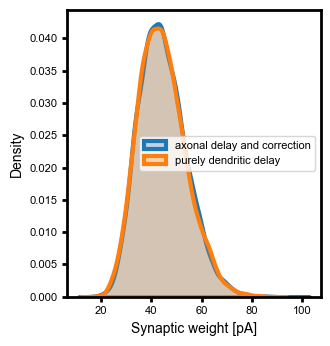

In [8]:
_, post_neuron = run(10000., 5., 0., enable_stdp=True, use_ax_delay=True)
weights_correction = nest.GetConnections(target=post_neuron, synapse_model="stdp_pl_synapse_hom_ax_delay").get("weight")
_, post_neuron = run(10000., 5., 0., enable_stdp=True, use_ax_delay=False)
weights_no_correction = nest.GetConnections(target=post_neuron, synapse_model="stdp_pl_synapse_hom").get("weight")

print("Jensen-Shannon divergence of weight distributions:", jensen_shannon_divergence(weights_correction, weights_no_correction))

fig, ax = plt.subplots(figsize=(single_column_in, 3.5))
set_font_sizes()
sns.distplot(weights_correction, hist=False, kde=True, kde_kws={'fill': True, 'linewidth': 3}, label="axonal delay and correction", ax=ax)
sns.distplot(weights_no_correction, hist=False, kde=True, kde_kws={'fill': True, 'linewidth': 3}, label="purely dendritic delay", ax=ax)
plt.setp(ax.spines.values(), linewidth=2)
ax.set_xlabel("Synaptic weight [pA]")
ax.tick_params(width=2)
plt.legend()
fig.tight_layout()
plt.show()

# Number of corrections for increasing fractions of axonal delays

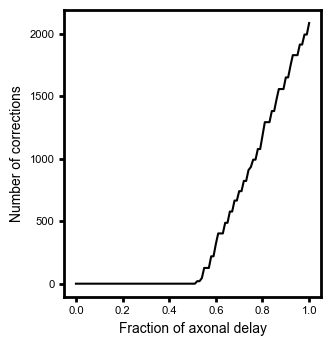

In [5]:
ax_perc = np.arange(0.0, 1.01, 0.01, dtype=np.float32)
num_corrections = np.empty(101, dtype=np.int32)
for i, p in enumerate(ax_perc):
    run(500., 5. * p, 5. * (1 - p), enable_stdp=False, use_ax_delay=True)
    num_corrections[i] = nest.kernel_status["num_corrections"]
fig, ax = plt.subplots(figsize=(single_column_in, 3.5))
set_font_sizes()
plt.plot(ax_perc, num_corrections, color="black")
plt.setp(ax.spines.values(), linewidth=2)
ax.set_xlabel("Fraction of axonal delay")
ax.set_ylabel("Number of corrections")  # average per neuron
ax.tick_params(width=2)
fig.tight_layout()
plt.show()